In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

2021-09-18 23:00:47.366654: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-18 23:00:47.366681: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
from nltk.corpus import stopwords

stops = stopwords.words('english')

train_df['text'] = train_df['text'].apply(lambda x: ' '.join([w for w in x.split(' ') if w.lower() not in stops]))

In [4]:
from sklearn.model_selection import train_test_split

X = train_df['text']
y = train_df['target']

In [44]:
output_size = max(X.map(lambda x: len(x.split(' '))))
output_size

52

## Building a neural network

In [45]:
from tensorflow.keras import layers

max_words = 10000

vectorizing_layer = layers.experimental.preprocessing.TextVectorization(max_tokens = max_words,
                                                                       output_mode='int',
                                                                       output_sequence_length=output_size)
vectorizing_layer.adapt(X)

In [54]:
model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(None,), dtype = tf.string))
model.add(vectorizing_layer)

model.add(layers.Embedding(max_words, 5)) # We use an embedding layer to transform data from 1000 word tokens to 32 inputs to the next layer.

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5, dropout = 0.2)))

model.add(layers.Dense(1, activation="sigmoid", name="predictions"))

model.compile(optimizer = 'Adam',
             loss = keras.losses.BinaryCrossentropy(),
             metrics = ['accuracy'])

In [55]:
epochs = 10
results = model.fit(X, y, epochs=epochs, validation_split=0.33, batch_size=20)

Epoch 1/10
255/255 [==============================] - 7s 21ms/step - loss: 0.6664 - accuracy: 0.5810 - val_loss: 0.6451 - val_accuracy: 0.5937
Epoch 2/10
255/255 [==============================] - 5s 19ms/step - loss: 0.5197 - accuracy: 0.7712 - val_loss: 0.5188 - val_accuracy: 0.7620
Epoch 3/10
255/255 [==============================] - 5s 19ms/step - loss: 0.3697 - accuracy: 0.8567 - val_loss: 0.4947 - val_accuracy: 0.7760
Epoch 4/10
255/255 [==============================] - 5s 20ms/step - loss: 0.2914 - accuracy: 0.8959 - val_loss: 0.5011 - val_accuracy: 0.7581
Epoch 5/10
255/255 [==============================] - 5s 20ms/step - loss: 0.2357 - accuracy: 0.9190 - val_loss: 0.5276 - val_accuracy: 0.7585
Epoch 6/10
255/255 [==============================] - 5s 20ms/step - loss: 0.1949 - accuracy: 0.9355 - val_loss: 0.5651 - val_accuracy: 0.7513
Epoch 7/10
255/255 [==============================] - 5s 20ms/step - loss: 0.1644 - accuracy: 0.9457 - val_loss: 0.6185 - val_accuracy: 0.7489

Text(0.5, 1.0, 'Accuracy')

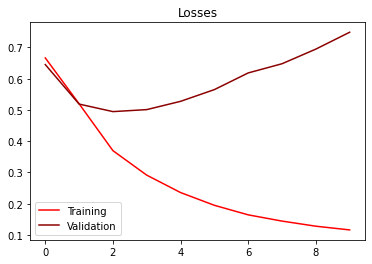

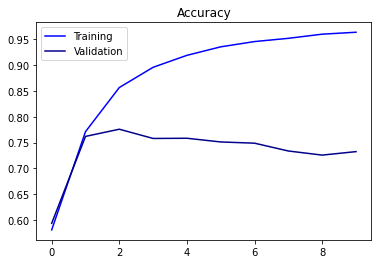

In [56]:
plt.figure()
sns.lineplot(x = range(0, epochs), y = results.history['loss'], color = 'red', label = "Training")
sns.lineplot(x = range(0, epochs), y = results.history['val_loss'], color = 'darkred', label = "Validation")
plt.title("Losses")

plt.figure()
sns.lineplot(x = range(0, epochs), y = results.history['accuracy'], color = 'blue', label = "Training")
sns.lineplot(x = range(0, epochs), y = results.history['val_accuracy'], color = 'darkblue', label = "Validation")
plt.title("Accuracy")

# Submitting predictions

In [57]:
test = pd.read_csv('test.csv')

test['target'] = np.where(model.predict(test['text']) > 0.5, 1, 0)

test[['id', 'target']].to_csv('submissions_nn.csv', index = False)